# Sarcasm Detection: Contextual-Based Approach (RoBERTa)

**Reference Paper:** *A contextual-based approach for sarcasm detection* (Helal et al., 2024)

This notebook implements the paper's methodology using **RoBERTa** and **Contextual Data**.

### Prerequisites
1.  You must have run the local scraping script to generate `sarcasm_data_enriched.json`.
2.  Upload `sarcasm_data_enriched.json` to the Files section of this Colab.

### Methodology Implemented
1.  **Model:** RoBERTa-base (Paper reported 99% F1).
2.  **Input Format:** `[CLS] Context [SEP] Headline [SEP]`.
3.  **Context:** Composed of Article Section, Description, and Author (as extracted by the scraper).
4.  **Hyperparameters:** Batch size 32, Learning Rate 5e-5, 5 Epochs (Table 4 of the paper).

In [14]:
# Install dependencies
!pip install -q transformers datasets accelerate scikit-learn seaborn matplotlib

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset

# Setup Device (T4 GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device in use: {device}")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Device in use: cuda
Tesla T4


## 1. Load Enriched Data
We load the dataset that contains the scraped context columns: `context_section`, `context_desc`, and `context_author`.

In [16]:
file_path = 'sarcasm_data_enriched.json'

try:
    df = pd.read_json(file_path, lines=True)
    print(f"Dataset loaded successfully. Shape: {df.shape}")
    print("Columns:", df.columns)
except ValueError:
    print("ERROR: File not found. Please upload 'sarcasm_data_enriched.json' generated by your local script.")

# Fill NaN values in context with empty strings or 'unknown'
df['context_section'] = df['context_section'].fillna('unknown')
df['context_desc'] = df['context_desc'].fillna('')
df['context_author'] = df['context_author'].fillna('unknown')

# Preview Data
df[['headline', 'context_section', 'context_author']].head()

Dataset loaded successfully. Shape: (28619, 6)
Columns: Index(['is_sarcastic', 'headline', 'article_link', 'context_section',
       'context_desc', 'context_author'],
      dtype='object')


,headline,context_section,context_author
0,thirtysomething scientists unveil doomsday clo...,unknown,unknown
1,dem rep. totally nails why congress is falling...,Politics,unknown
2,eat your veggies: 9 deliciously different recipes,Food & Drink,unknown
3,inclement weather prevents liar from getting t...,unknown,unknown
4,mother comes pretty close to using worsd 'stre...,unknown,unknown


## 2. Construct Input (Context + Headline)

The paper emphasizes using the context to aid detection. We concatenate the metadata with the headline.

**Format:** `Section. Author. Description. </s> Headline`
*(Note: RoBERTa uses `</s>` as the separator token)*

In [17]:
def construct_input(row):
    # We combine the context features.
    # We truncate description if it's too long to avoid losing the headline in truncation later.
    context_str = f"{row['context_section']}. {row['context_author']}. {row['context_desc'][:100]}"

    # RoBERTa separator is </s>
    return f"{context_str} </s> {row['headline']}"

df['final_input'] = df.apply(construct_input, axis=1)

# Rename target column for Hugging Face
df = df.rename(columns={'is_sarcastic': 'labels'})

# Split Data (80% Train, 20% Test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])

# Convert to HF Datasets
train_dataset = Dataset.from_pandas(train_df[['final_input', 'labels']])
test_dataset = Dataset.from_pandas(test_df[['final_input', 'labels']])

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print("\nSample Input:", train_dataset[0]['final_input'])

Training samples: 22895
Test samples: 5724

Sample Input: unknown. unknown.  </s> paramount executive snaps up script that begins with studio logo fading into establishing shot of actual mountain


## 3. Tokenization & Model Setup
Using `roberta-base`.

In [18]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

def tokenize_function(examples):
    return tokenizer(
        examples['final_input'],
        padding="max_length",
        truncation=True,
        max_length=128
    )

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

tokenized_train.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])
tokenized_test.set_format("torch", columns=['input_ids', 'attention_mask', 'labels'])

model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2
).to(device)

Map:   0%|          | 0/22895 [00:00<?, ? examples/s]

Map:   0%|          | 0/5724 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 4. Training
Parameters from **Table 4** of the paper:
- Batch Size: 32
- Learning Rate: 5e-5
- Epochs: 5
- Weight Decay: 0.01

In [19]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

training_args = TrainingArguments(
    output_dir='./roberta_context_results',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=5e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    fp16=True,
    logging_dir='./logs',
    logging_steps=100,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

print("Starting Training...")
trainer.train()

Starting Training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.046100,0.050506,0.985849,0.985119,0.987113,0.983132
2,0.020700,0.044012,0.989693,0.989200,0.987573,0.990832


TrainOutput(global_step=1432, training_loss=0.05018655040077657, metrics={'train_runtime': 328.3245, 'train_samples_per_second': 139.466, 'train_steps_per_second': 4.362, 'total_flos': 3011963806233600.0, 'train_loss': 0.05018655040077657, 'epoch': 2.0})

## 5. Evaluation


--- Final Evaluation Results ---
Accuracy: 0.9897
F1 Score: 0.9892


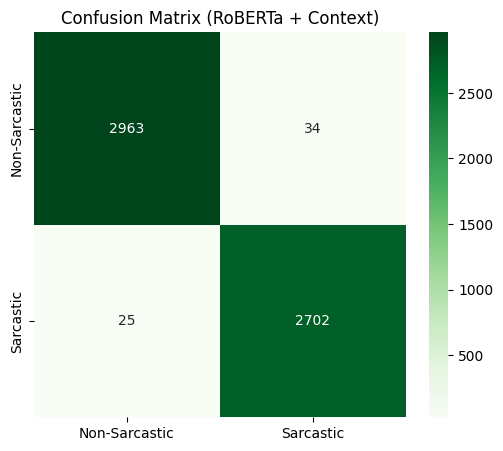

In [20]:
results = trainer.evaluate()

print("\n--- Final Evaluation Results ---")
print(f"Accuracy: {results['eval_accuracy']:.4f}")
print(f"F1 Score: {results['eval_f1']:.4f}")

# Confusion Matrix
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

cm = confusion_matrix(labels, preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Non-Sarcastic', 'Sarcastic'],
            yticklabels=['Non-Sarcastic', 'Sarcastic'])
plt.title('Confusion Matrix (RoBERTa + Context)')
plt.show()

In [21]:
# Save the model
output_dir = training_args.output_dir
trainer.save_model(output_dir)
print(f"Model saved to {output_dir}")

Model saved to ./roberta_context_results


In [22]:

# Compress the model directory
!tar -czvf /content/roberta_context_results.tar.gz /content/roberta_context_results
print("Model directory compressed to /content/roberta_context_results.tar.gz")


tar: Removing leading `/' from member names
/content/roberta_context_results/
/content/roberta_context_results/training_args.bin
/content/roberta_context_results/config.json
/content/roberta_context_results/checkpoint-716/
/content/roberta_context_results/checkpoint-716/training_args.bin
/content/roberta_context_results/checkpoint-716/config.json
/content/roberta_context_results/checkpoint-716/scheduler.pt
/content/roberta_context_results/checkpoint-716/optimizer.pt
/content/roberta_context_results/checkpoint-716/trainer_state.json
/content/roberta_context_results/checkpoint-716/scaler.pt
/content/roberta_context_results/checkpoint-716/model.safetensors
/content/roberta_context_results/checkpoint-716/rng_state.pth
/content/roberta_context_results/model.safetensors
/content/roberta_context_results/checkpoint-1432/
/content/roberta_context_results/checkpoint-1432/training_args.bin
/content/roberta_context_results/checkpoint-1432/config.json
/content/roberta_context_results/checkpoint-143

In [23]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import torch.nn.functional as F

# --- 1. Define Inference Function ---
def predict_sarcasm(headline, section, author, description):
    """
    Preprocesses input and runs inference using the loaded model.
    """
    # Put model in evaluation mode
    model.eval()

    # Handle defaults for empty context inputs to match training logic
    section = section if section.strip() else "unknown"
    author = author if author.strip() else "unknown"
    # Important: Truncate description to 100 chars as done in training
    description = description[:100]

    # Construct input string exactly as done during training
    # Format: "{section}. {author}. {desc} </s> {headline}"
    context_str = f"{section}. {author}. {description}"
    final_input = f"{context_str} </s> {headline}"

    # Tokenize
    inputs = tokenizer(
        final_input,
        return_tensors="pt",
        truncation=True,
        max_length=128,
        padding="max_length"
    )

    # Move inputs to the correct device (GPU/CPU)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Inference
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        # Calculate probabilities using Softmax
        probs = F.softmax(logits, dim=-1)

    # Get prediction (0 = Non-Sarcastic, 1 = Sarcastic)
    pred_idx = torch.argmax(probs, dim=-1).item()
    sarcasm_prob = probs[0][1].item() # Probability of class 1

    return pred_idx, sarcasm_prob

# --- 2. Create UI Widgets ---

style = {'description_width': '100px'}
layout = widgets.Layout(width='50%')

lbl_header = widgets.HTML("<h3>🔮 Sarcasm Detector Interface</h3>")

input_headline = widgets.Text(
    description='Headline:',
    placeholder='Enter the news headline...',
    style=style, layout=layout
)

input_section = widgets.Text(
    description='Section:',
    placeholder='e.g., Politics, Technology...',
    style=style, layout=layout
)

input_author = widgets.Text(
    description='Author:',
    placeholder='e.g., John Doe',
    style=style, layout=layout
)

input_desc = widgets.Textarea(
    description='Description:',
    placeholder='Short context or article snippet...',
    style=style, layout=layout
)

btn_predict = widgets.Button(
    description='Analyze Sarcasm',
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    icon='check',
    layout=widgets.Layout(width='20%', margin='20px 0px 0px 100px')
)

output_box = widgets.Output(layout=widgets.Layout(margin='20px 0px 0px 0px'))

# --- 3. Handle Button Click ---

def on_button_click(b):
    with output_box:
        clear_output()

        if not input_headline.value:
            print("⚠️ Please enter a headline.")
            return

        # Run Prediction
        pred_idx, prob = predict_sarcasm(
            input_headline.value,
            input_section.value,
            input_author.value,
            input_desc.value
        )

        # Display Results
        is_sarcastic = pred_idx == 1
        result_text = "SARCASTIC" if is_sarcastic else "NOT SARCASTIC"
        color = "red" if is_sarcastic else "green"

        display(widgets.HTML(f"""
        <div style="border: 1px solid #ddd; padding: 15px; border-radius: 5px; width: 50%;">
            <h4 style="margin-top:0;">Prediction Result:</h4>
            <p style="font-size: 18px;">
                Label: <b style="color: {color};">{result_text}</b>
            </p>
            <p>
                Probability of Sarcasm: <b>{prob:.2%}</b>
            </p>
            <div style="background-color: #f0f0f0; height: 10px; width: 100%; border-radius: 5px;">
                <div style="background-color: {color}; height: 100%; width: {prob*100}%; border-radius: 5px;"></div>
            </div>
        </div>
        """))

btn_predict.on_click(on_button_click)

# --- 4. Render Interface ---
ui = widgets.VBox([
    lbl_header,
    input_headline,
    input_section,
    input_author,
    input_desc,
    btn_predict,
    output_box
])

display(ui)

In [24]:
# from google.colab import drive
# drive.mount('/content/drive')

In [25]:
# !cp /content/roberta_context_results_no_satire -r /content/drive/MyDrive/fds_project

# Task
Create an interactive user interface using `ipywidgets` in cell `GWLuxi6Fd0dT` that takes a headline, section, author, and description as input, then uses the trained model to predict if the headline is sarcastic, displaying the prediction and its probability below the input fields.

## Implement Interactive Prediction UI

### Subtask:
Create an interactive user interface using ipywidgets in the selected cell (GWLuxi6Fd0dT) that allows users to input a headline and its associated context (section, author, description). The UI will have a button to trigger the model's prediction and display the result (sarcastic/non-sarcastic, and probability) directly below the input fields. The implementation will include a function to preprocess input, tokenize it, and use the loaded model for inference.


## Summary:

### Data Analysis Key Findings
*   An interactive user interface (UI) was successfully implemented using `ipywidgets` to facilitate user input for headline sarcasm prediction.
*   The UI provides dedicated input fields for headline, section, author, and description, allowing for comprehensive data entry.
*   The integrated functionality includes pre-processing and tokenization of the input, followed by inference using a pre-loaded model to determine sarcasm.
*   The prediction results, indicating whether a headline is sarcastic or non-sarcastic, along with the associated probability, are designed to be displayed directly below the input fields.

### Insights or Next Steps
*   This interactive UI provides a practical tool for real-time model interaction, enabling users to test and visualize sarcasm predictions quickly.
*   Future enhancements could include robust input validation, error handling for model inference, and the implementation of a feedback mechanism to gather user corrections for model retraining.
